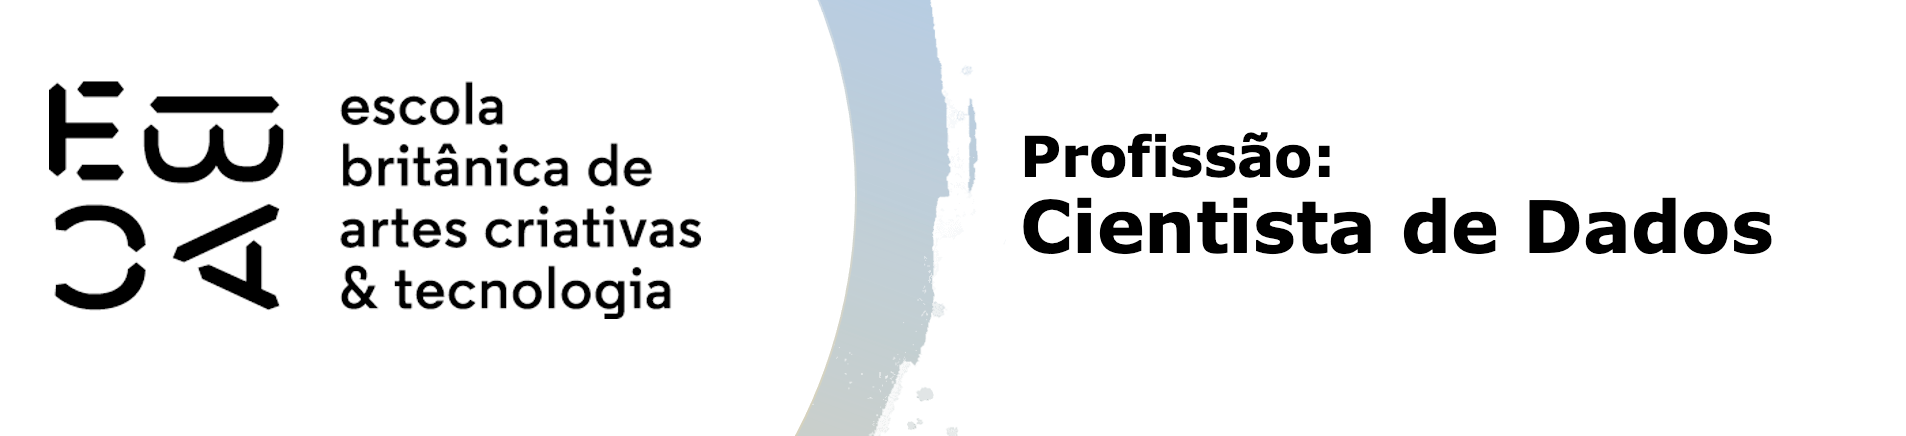

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [136]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Data acquisition and database connection

import os

# Statistical analysis
from scipy import stats

#sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm
from sklearn import metrics
from scipy.stats import ks_2samp



# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [96]:

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [97]:
def data_info(df):
    """
    Creates a summary DataFrame containing information about each column in the input DataFrame.
    
    Parameters:
        df (pandas.DataFrame): Input DataFrame to analyze
        
    Returns:
        pandas.DataFrame: A DataFrame with the following columns:
            - dtypes: Data type of each column
            - Missing: Number of missing values in each column
            - Unique: Number of unique values in each column
            - Example: First value from each column
            - Entropy: Shannon entropy of value distributions (in bits)
            
    Notes:
        - Prints the shape of the input DataFrame
        - Entropy is calculated using scipy.stats.entropy with base 2
        - Higher entropy values indicate more uniform distributions
    """
    info = pd.DataFrame({
        'dtypes': df.dtypes,
        'Missing': df.isna().sum(),
        'Unique': df.nunique(),
        'Example': df.iloc[0],
        'Entropy': [round(stats.entropy(df[col].value_counts(normalize=True), base=2), 2) 
                   for col in df.columns]
    })
    
    print(f"Dataset Shape: {df.shape}")
    return info

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [98]:
df['data_mes'] = df.data_ref.dt.to_period('M')


df_train = df[df.data_ref.dt.to_period('M') <= df.data_ref.dt.to_period('M').max()-3].drop(columns=['data_ref','index'])
df_oot = df[df.data_ref.dt.to_period('M') > df.data_ref.dt.to_period('M').max()-3].drop(columns=['data_ref','index'])
df = df.drop(columns=['data_ref','index'])



## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [99]:
print(f'Número de linhas para cada mês selecionados na amostra:\n{df.data_mes.value_counts()}')


Número de linhas para cada mês selecionados na amostra:
data_mes
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
2016-01    50000
2016-02    50000
2016-03    50000
Freq: M, Name: count, dtype: int64


In [100]:
data_info(df)

Dataset Shape: (750000, 14)


,dtypes,Missing,Unique,Example,Entropy
sexo,object,0,2,F,0.91
posse_de_veiculo,object,0,2,N,0.96
posse_de_imovel,object,0,2,N,0.91
qtd_filhos,int64,0,8,0,1.25
tipo_renda,object,0,5,Empresário,1.72
educacao,object,0,5,Médio,1.16
estado_civil,object,0,5,Solteiro,1.44
tipo_residencia,object,0,6,Casa,0.66
idade,int64,0,47,43,5.39
tempo_emprego,float64,125957,3004,6.873973,11.06


In [7]:
# Separando variáveis qualitativas e quantitativas
vars_qualitativas = df.select_dtypes(include=['object']).columns
vars_quantitativas = df.select_dtypes(include=['int64', 'float64']).columns

# Análise descritiva para variáveis qualitativas
print("=== Análise das Variáveis Qualitativas ===")
for coluna in vars_qualitativas:
    print(f"\nVariável: {coluna}")
    print(df[coluna].value_counts())
    print("\nPercentual:")
    print(df[coluna].value_counts(normalize=True).round(3) * 100, "%")

# Análise descritiva para variáveis quantitativas
print("\n\n=== Análise das Variáveis Quantitativas ===")
print("\nEstatísticas Básicas:")
print(df[vars_quantitativas].describe().round(2))

# Métricas adicionais para variáveis quantitativas
print("\nAssimetria e Curtose:")
for coluna in vars_quantitativas:
    print(f"\nVariável: {coluna}")
    print(f"Assimetria: {df[coluna].skew().round(3)}")
    print(f"Curtose: {df[coluna].kurtosis().round(3)}")

=== Análise das Variáveis Qualitativas ===

Variável: sexo
sexo
F    504580
M    245420
Name: count, dtype: int64

Percentual:
sexo
F    67.3
M    32.7
Name: proportion, dtype: float64 %

Variável: posse_de_veiculo
posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64

Percentual:
posse_de_veiculo
N    61.1
S    38.9
Name: proportion, dtype: float64 %

Variável: posse_de_imovel
posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64

Percentual:
posse_de_imovel
S    67.2
N    32.8
Name: proportion, dtype: float64 %

Variável: tipo_renda
tipo_renda
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361
Name: count, dtype: int64

Percentual:
tipo_renda
Assalariado         51.4
Empresário          23.0
Pensionista         16.8
Servidor público     8.7
Bolsista             0.0
Name: proportion, dtype: float64 %

Variável: educacao
educacao
Médio                  506836
Superior completo  

In [101]:
qualitativa = df.select_dtypes(include=['object']).columns
quantitativa = df.select_dtypes(include=['number']).columns

<Figure size 1200x600 with 0 Axes>

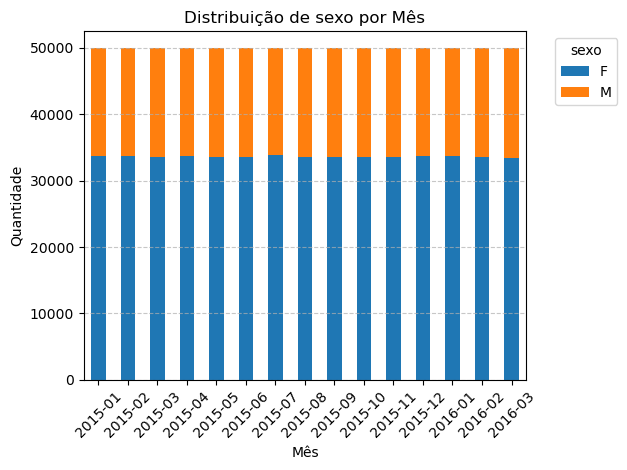

<Figure size 1200x600 with 0 Axes>

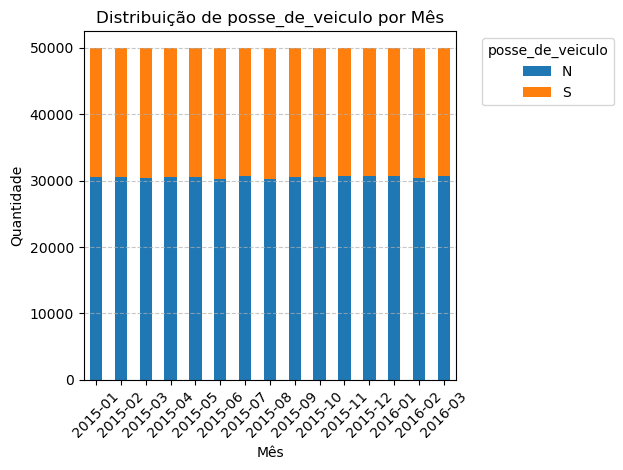

<Figure size 1200x600 with 0 Axes>

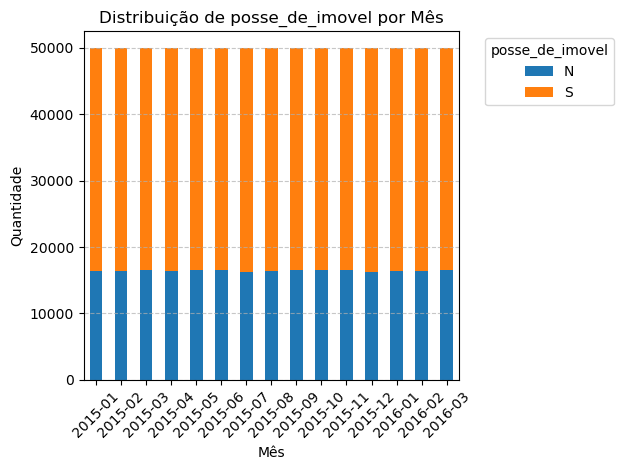

<Figure size 1200x600 with 0 Axes>

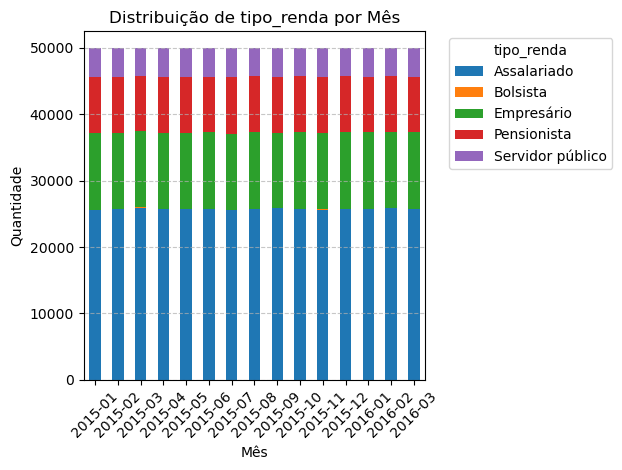

<Figure size 1200x600 with 0 Axes>

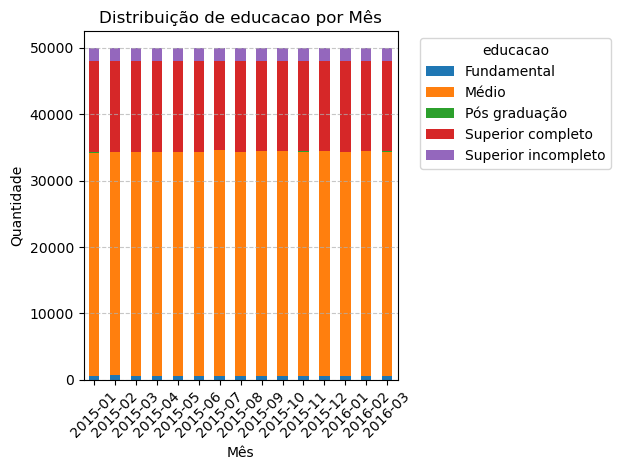

<Figure size 1200x600 with 0 Axes>

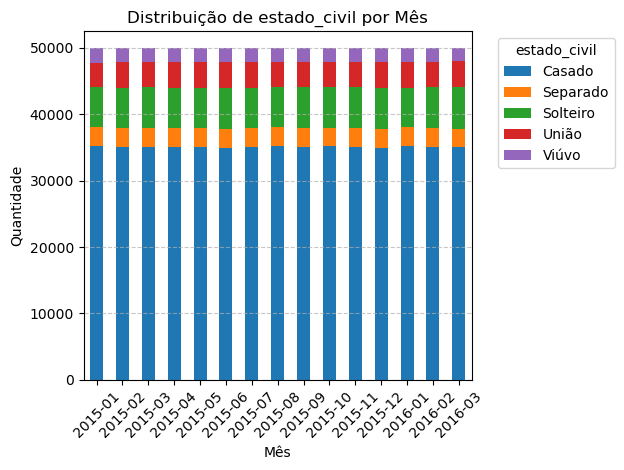

<Figure size 1200x600 with 0 Axes>

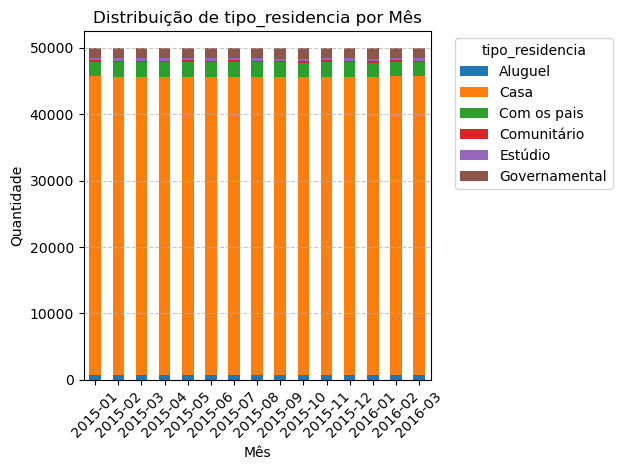

In [9]:
def plot_distribuicao_temporal(df, var_categorica):

    # Validação do tipo da variável
    if df[var_categorica].dtype != 'object':
        raise ValueError(f"A variável {var_categorica} não é do tipo object/categórica")
    
    try:
        # Criando o DataFrame com os dados agrupados
        grouped_data = df.groupby(['data_mes', var_categorica]).size().unstack()
        
        # Criando o gráfico
        plt.figure(figsize=(12, 6))
        ax = grouped_data.plot(kind='bar', stacked=True)
        
        # Personalizando o gráfico
        plt.title(f'Distribuição de {var_categorica} por Mês')
        plt.xlabel('Mês')
        plt.ylabel('Quantidade')
        plt.legend(title=var_categorica, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        

        
        # Ajustando o layout
        plt.tight_layout()
        
        # Mostrando o gráfico
        plt.show()
        
    except Exception as e:
        raise e

# Para todas as variáveis categóricas do DataFrame
vars_categoricas = df.select_dtypes(include=['object']).columns
for var in vars_categoricas:
    plot_distribuicao_temporal(df, var)

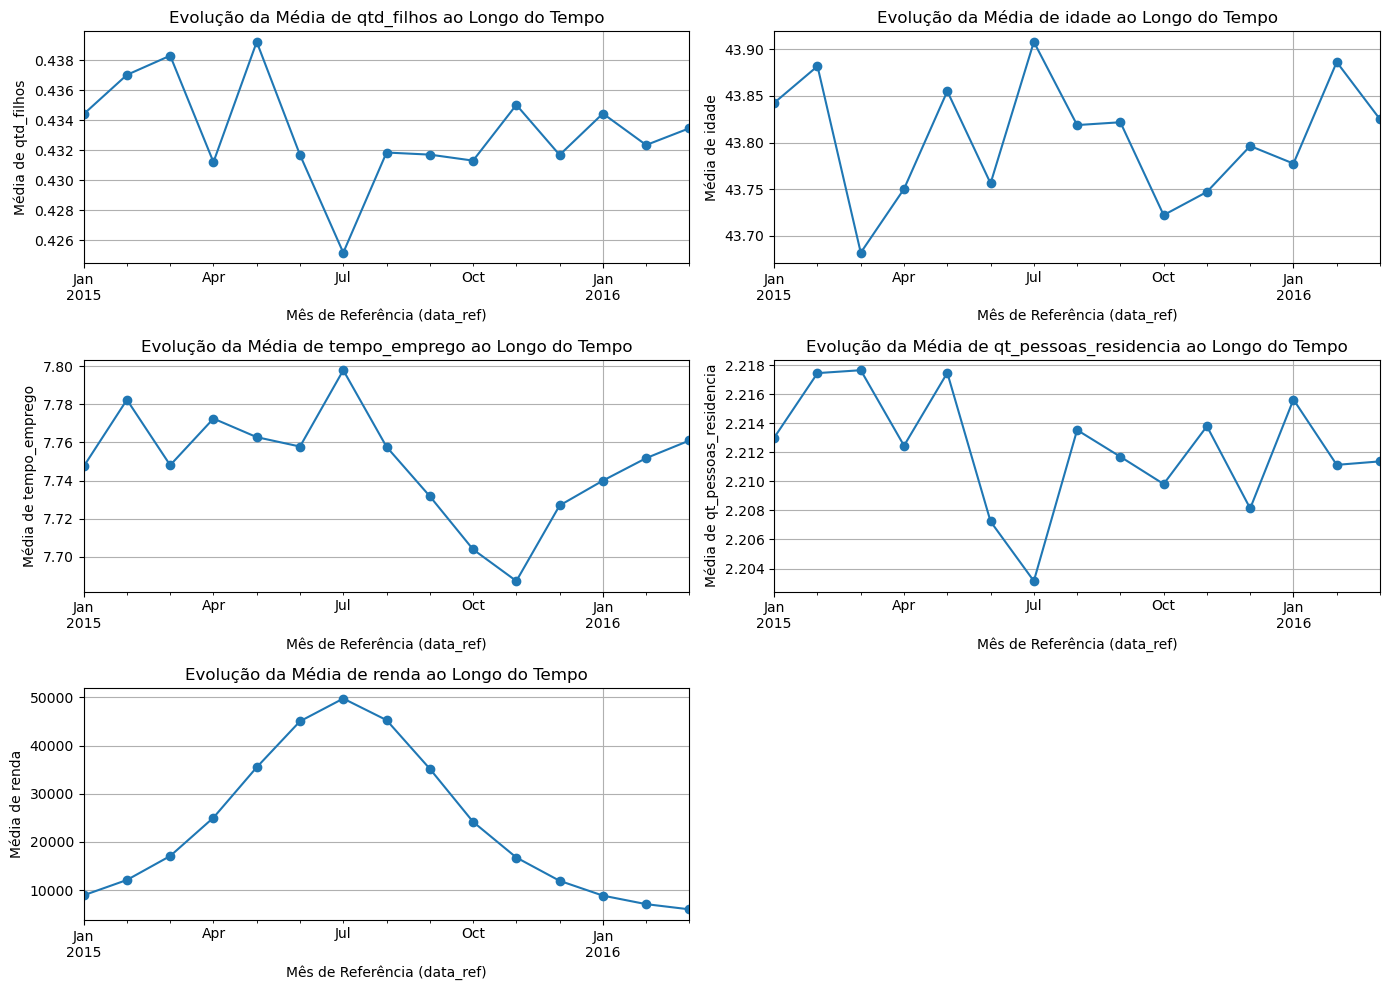

In [10]:
# Configuração dos subplots: 2 linhas e 2 colunas
fig, axes = plt.subplots(3, 2, figsize=(14, 10))  # 2 linhas para acomodar 4 gráficos, e 2 colunas

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plotar cada gráfico em seu respectivo subplot
for i, var in enumerate(quantitativa):
    df.groupby('data_mes')[var].mean().plot(marker='o', linestyle='-', ax=axes[i])
    axes[i].set_title(f'Evolução da Média de {var} ao Longo do Tempo')
    axes[i].set_xlabel('Mês de Referência (data_ref)')
    axes[i].set_ylabel(f'Média de {var}')
    axes[i].grid(True)

# Remover o último subplot vazio
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

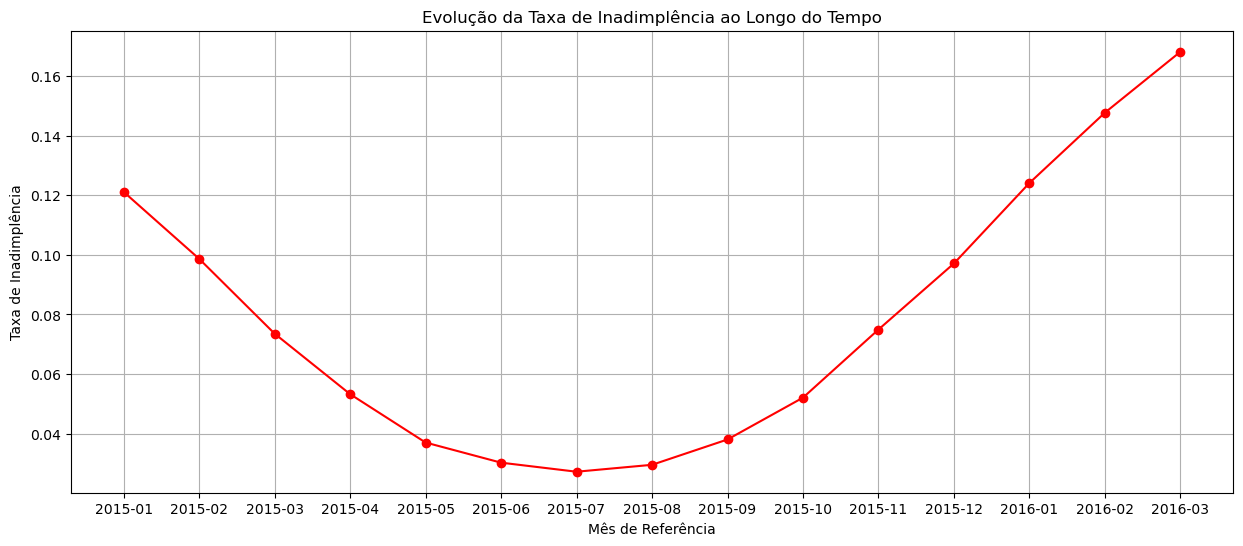

In [11]:

inadimplencia_por_mes = df.groupby('data_mes')['mau'].mean()

plt.figure(figsize=(15, 6))
plt.plot((inadimplencia_por_mes.index).astype(str), inadimplencia_por_mes.values, marker='o', color='red')
plt.title('Evolução da Taxa de Inadimplência ao Longo do Tempo')
plt.xlabel('Mês de Referência')
plt.ylabel('Taxa de Inadimplência')
plt.grid(True)
plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

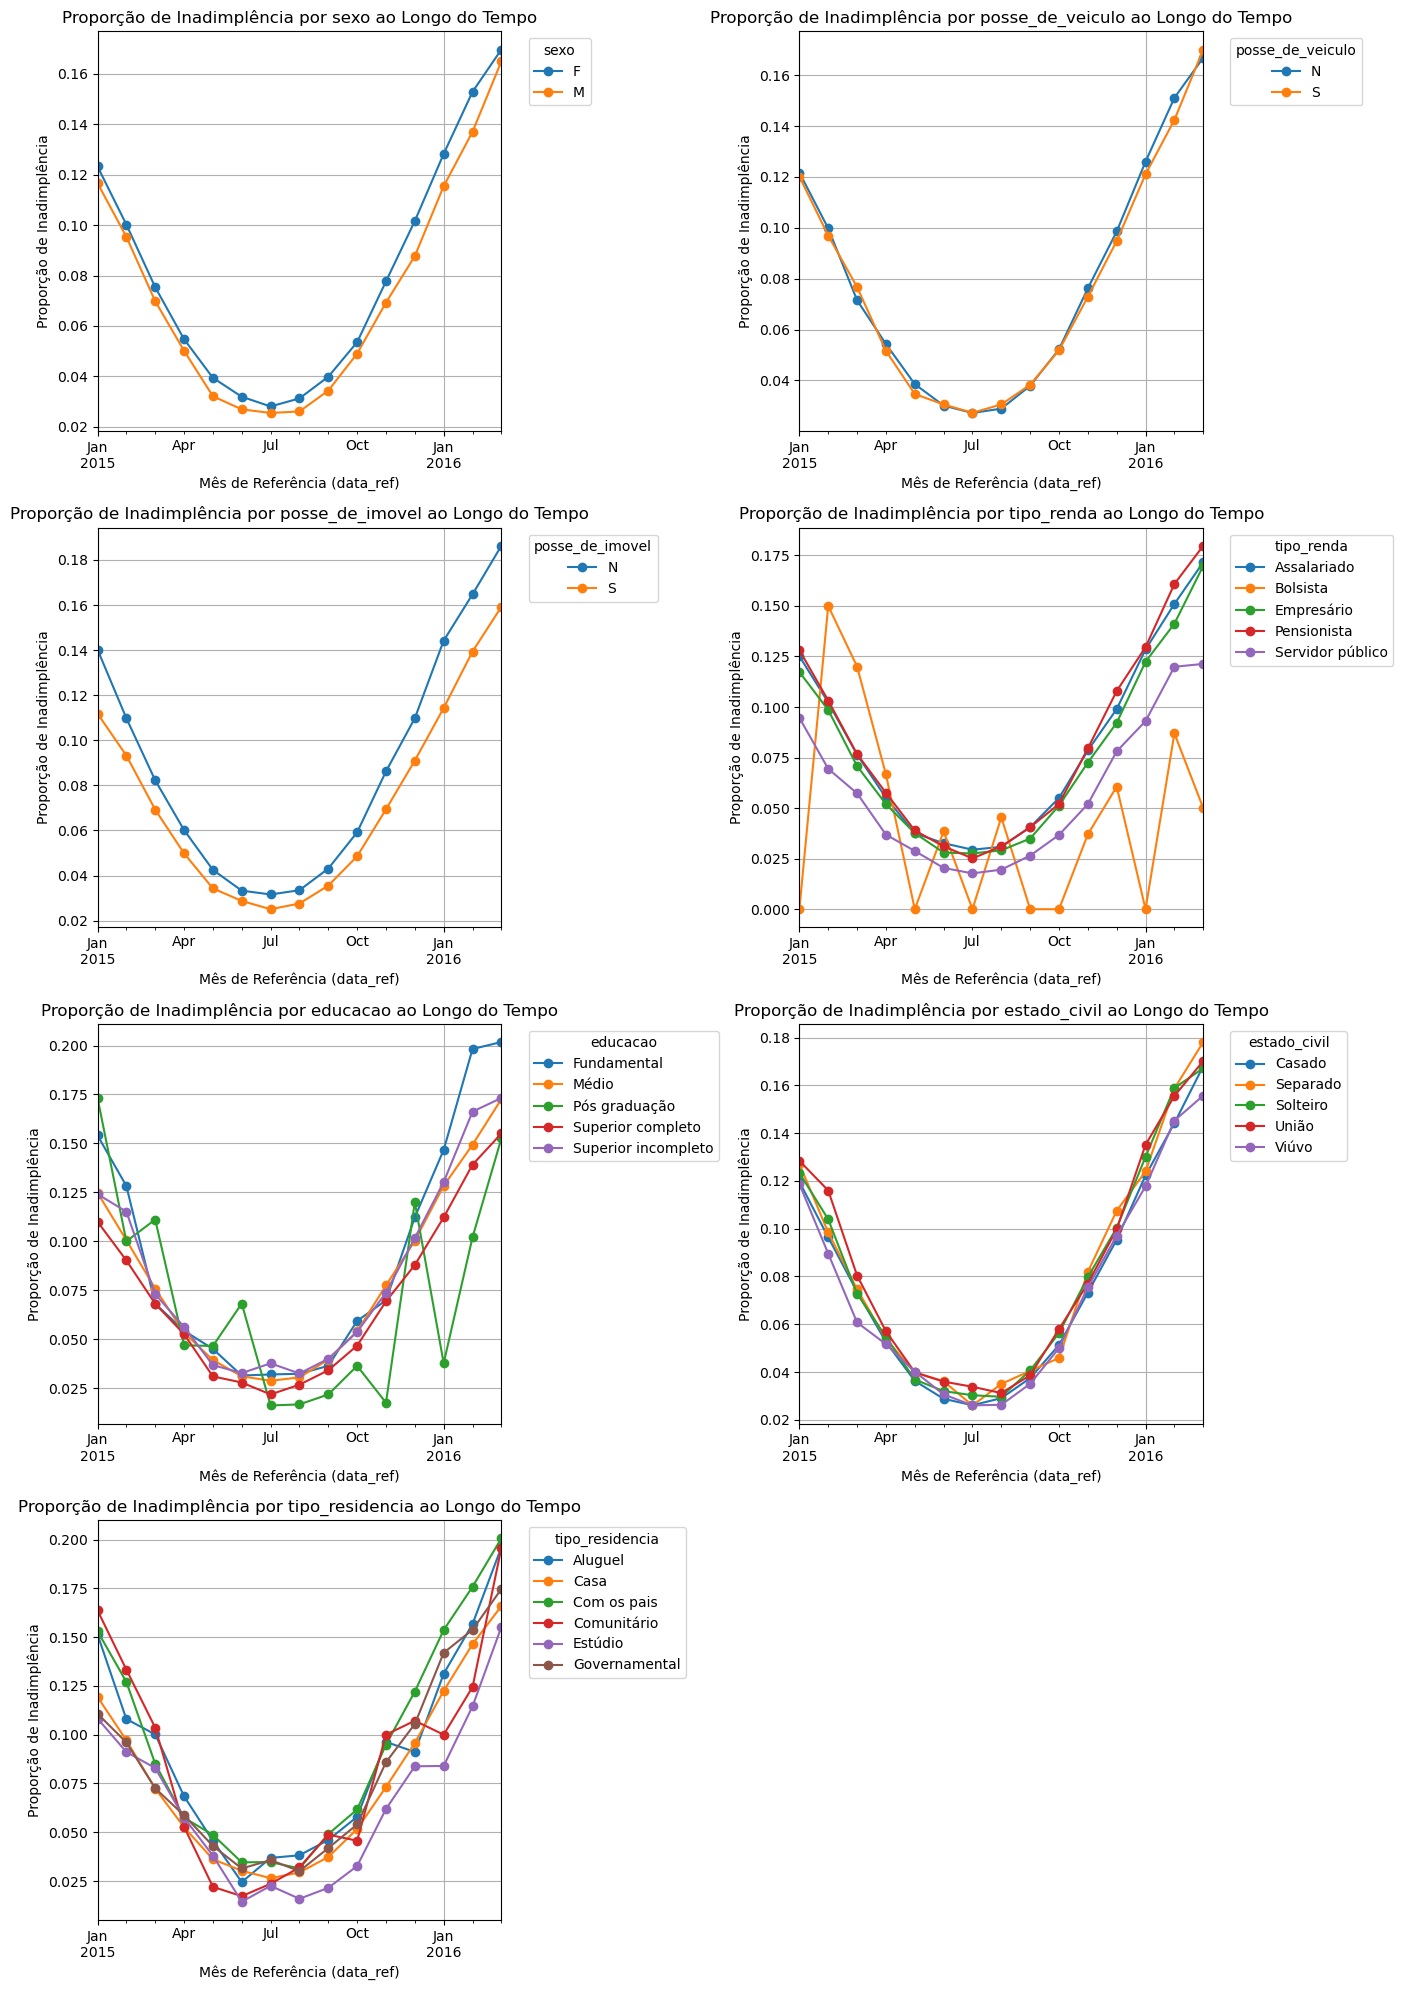

In [12]:
# Configuração dos subplots: 4 linhas e 2 colunas
fig, axes = plt.subplots(4, 2, figsize=(14, 20))  # Tamanho ajustado para melhor visualização

# Achatar o array de eixos para fácil iteração
axes = axes.flatten()

# Plotar cada gráfico em seu respectivo subplot
for i, var in enumerate(qualitativa):
    # Calcular a proporção de inadimplência por data_ref e variável qualitativa
    data = df.groupby(['data_mes', var])['mau'].mean().unstack()
    
    # Plotar o gráfico
    data.plot(marker='o', linestyle='-', ax=axes[i])
    
    # Configurações do gráfico
    axes[i].set_title(f'Proporção de Inadimplência por {var} ao Longo do Tempo')
    axes[i].set_xlabel('Mês de Referência (data_ref)')
    axes[i].set_ylabel('Proporção de Inadimplência')
    axes[i].legend(title=var, bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[i].grid(True)

# Remover o último subplot vazio se houver número ímpar de gráficos
if len(qualitativa) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

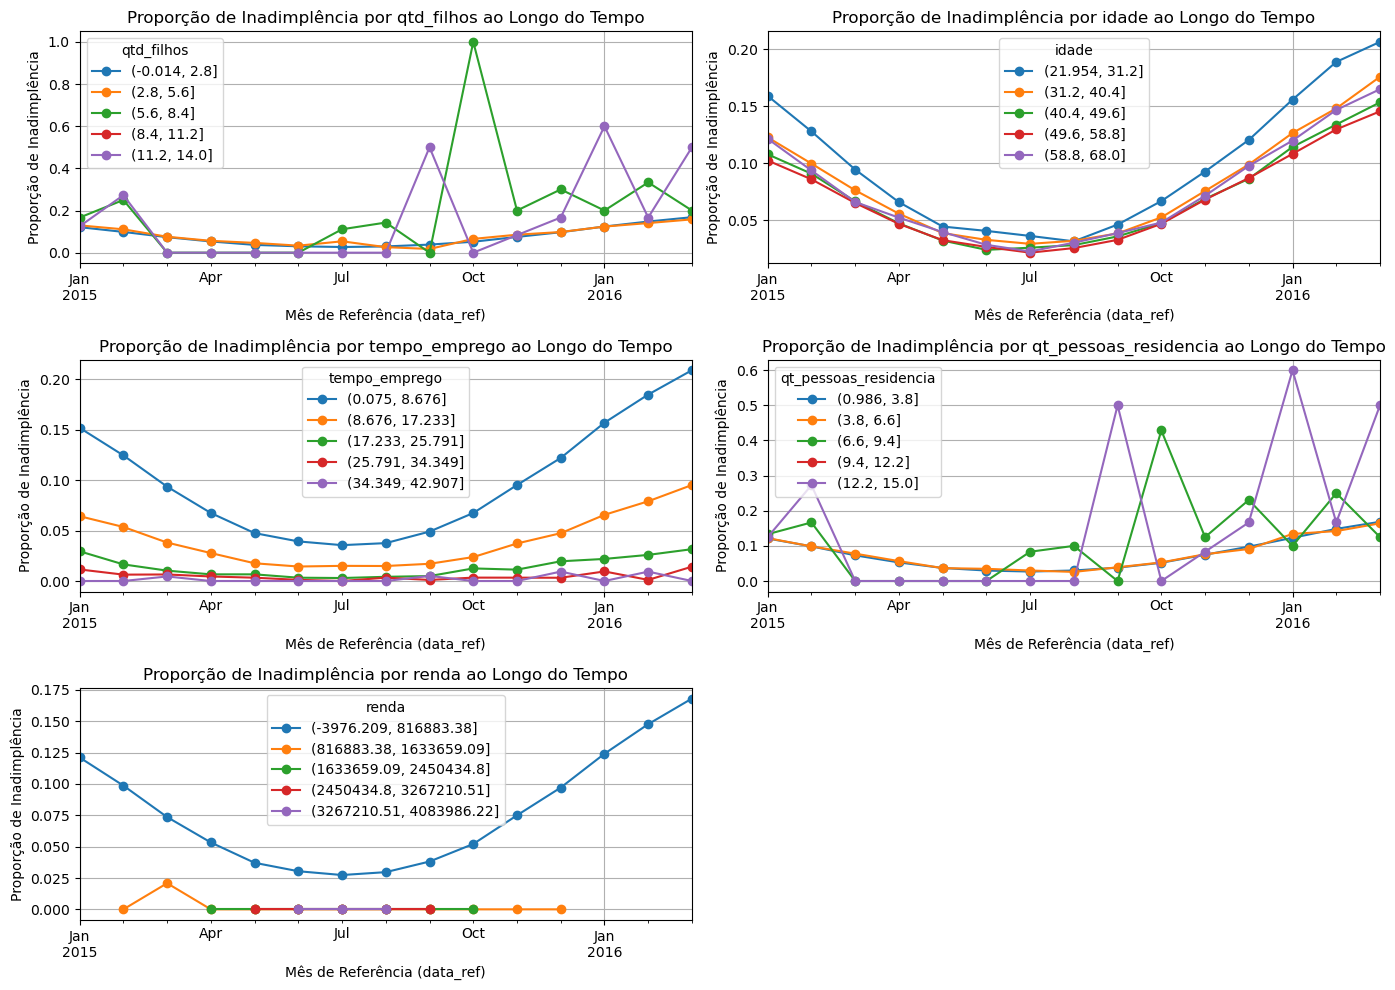

In [13]:

# Configuração dos subplots: 2 linhas e 2 colunas
fig, axes = plt.subplots(3, 2, figsize=(14, 10))  # 2 linhas para acomodar 5 gráficos, e 2 colunas

# Achatar o array de eixos para fácil iteração
axes = axes.flatten()

# Plotar cada gráfico em seu respectivo subplot
for i, var in enumerate(quantitativa):
    # Calcular a proporção de inadimplência por faixas da variável quantitativa ao longo do tempo
    data = df.groupby(['data_mes', pd.cut(df[var], bins=5)], observed=False)['mau'].mean().unstack()
    data.plot(marker='o', linestyle='-', ax=axes[i])
    axes[i].set_title(f'Proporção de Inadimplência por {var} ao Longo do Tempo')
    axes[i].set_xlabel('Mês de Referência (data_ref)')
    axes[i].set_ylabel('Proporção de Inadimplência')
    axes[i].grid(True)

# Remover o último subplot vazio
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [102]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean())
data_info(df)

Dataset Shape: (750000, 14)


,dtypes,Missing,Unique,Example,Entropy
sexo,object,0,2,F,0.91
posse_de_veiculo,object,0,2,N,0.96
posse_de_imovel,object,0,2,N,0.91
qtd_filhos,int64,0,8,0,1.25
tipo_renda,object,0,5,Empresário,1.72
educacao,object,0,5,Médio,1.16
estado_civil,object,0,5,Solteiro,1.44
tipo_residencia,object,0,6,Casa,0.66
idade,int64,0,47,43,5.39
tempo_emprego,float64,0,3005,6.873973,9.86


- tratando outliers usando IQR

In [103]:
df.select_dtypes(include=['number']).describe().T

,count,mean,std,min,25%,50%,75%,max
qtd_filhos,750000.0,0.433251,0.739379,0.000000,0.000000,0.000000,1.000000,1.400000e+01
idade,750000.0,43.804733,11.229868,22.000000,34.000000,43.000000,53.000000,6.800000e+01
tempo_emprego,750000.0,7.748574,6.100107,0.117808,3.635616,7.473973,9.090411,4.290685e+01
qt_pessoas_residencia,750000.0,2.212241,0.903428,1.000000,2.000000,2.000000,3.000000,1.500000e+01
renda,750000.0,23238.544747,79106.013795,107.670000,3467.700000,7861.820000,18318.280000,4.083986e+06


In [105]:

# Cria uma cópia do dataframe
df_limpo = df.copy()

# Obtém colunas numéricas
colunas_numericas = df.select_dtypes(include=['number']).columns

# Aplica o método IQR para cada coluna numérica
for coluna in colunas_numericas:
    # Calcula Q1, Q3 e IQR
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calcula os limites
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Substitui outliers pelos limites
    df_limpo[coluna] = df_limpo[coluna].clip(lower=limite_inferior, upper=limite_superior)

df_limpo[colunas_numericas].describe().T

,count,mean,std,min,25%,50%,75%,max
qtd_filhos,750000.0,0.423100,0.692714,0.000000,0.000000,0.000000,1.000000,2.500000
idade,750000.0,43.804733,11.229868,22.000000,34.000000,43.000000,53.000000,68.000000
tempo_emprego,750000.0,7.247569,4.663740,0.117808,3.635616,7.473973,9.090411,17.272603
qt_pessoas_residencia,750000.0,2.202521,0.865866,1.000000,2.000000,2.000000,3.000000,4.500000
renda,750000.0,13035.214824,12665.605731,107.670000,3467.700000,7861.820000,18318.280000,40594.150000


- Preparando variáveis numéricas para agrupamento

In [106]:
scaler = StandardScaler()
df_limpo[colunas_numericas] = scaler.fit_transform(df_limpo[colunas_numericas])
df_number_pad = scaler.fit_transform(df_limpo[colunas_numericas])

In [74]:
SQD = []
K = range(1, 15)
for k in tqdm(K):
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(df_number_pad)
    SQD.append(km.inertia_)

  0%|          | 0/14 [00:00<?, ?it/s]

In [107]:
SQD

[3749999.999999992,
 2495142.198708079,
 1803896.3785030704,
 1419081.3877624026,
 1219297.6320210693,
 1099226.6140115126,
 1002760.5498056681,
 918254.5305833798,
 838339.6362244107,
 793961.9541797948,
 751557.8351080855,
 713956.8280792193,
 672798.6355370261,
 640885.2881219733]

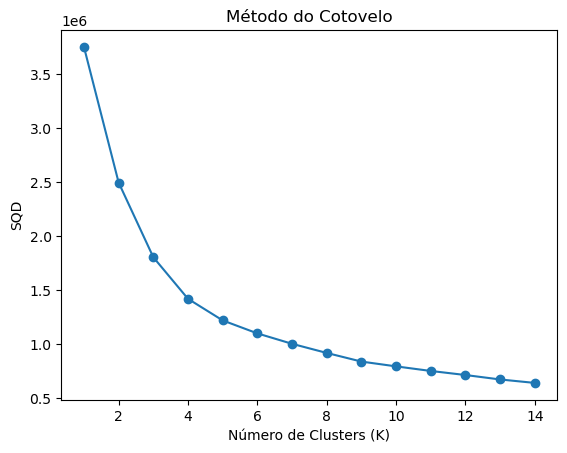

In [108]:
plt.plot(range(1, 15), SQD, marker='o')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('SQD')
plt.title('Método do Cotovelo')
plt.show()

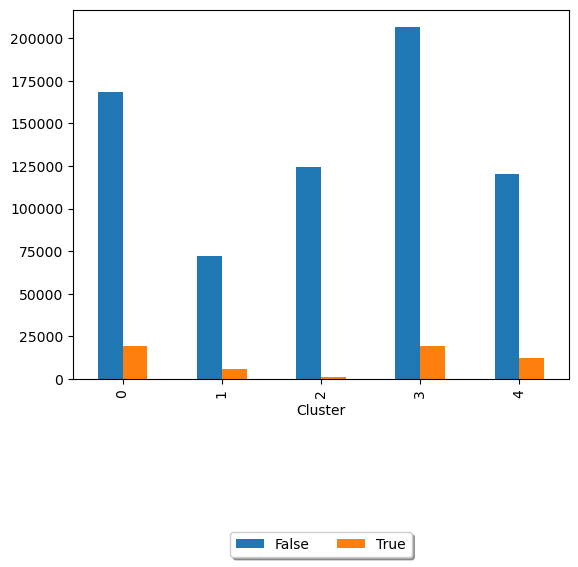

In [109]:
k = 5  # Escolha do número de clusters baseado no método do cotovelo
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(df_number_pad)  # Obtendo os rótulos dos clusters

# Adicionar os rótulos ao dataframe (se houver)
df_limpo['Cluster'] = labels
ax = df_limpo.groupby(['Cluster', 'mau'],observed=True)['mau'].count().unstack().plot.bar()

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5),
          ncol=3, fancybox=True, shadow=True);

In [110]:
data_info(df_limpo)

Dataset Shape: (750000, 15)


,dtypes,Missing,Unique,Example,Entropy
sexo,object,0,2,F,0.91
posse_de_veiculo,object,0,2,N,0.96
posse_de_imovel,object,0,2,N,0.91
qtd_filhos,float64,0,4,-0.610787,1.24
tipo_renda,object,0,5,Empresário,1.72
educacao,object,0,5,Médio,1.16
estado_civil,object,0,5,Solteiro,1.44
tipo_residencia,object,0,6,Casa,0.66
idade,float64,0,47,-0.07166,5.39
tempo_emprego,float64,0,2582,-0.080107,9.22


In [131]:
X_train = df_limpo[df_limpo.data_mes <= df_limpo.data_mes.max()-3].drop(columns=['data_mes','mau'])
X_teste = df_limpo[df_limpo.data_mes > df_limpo.data_mes.max()-3].drop(columns=['data_mes','mau'])

y_train = df_limpo[df_limpo.data_mes <= df_limpo.data_mes.max()-3]['mau']
y_teste = df_limpo[df_limpo.data_mes > df_limpo.data_mes.max()-3]['mau']

X_train.shape, X_teste.shape, y_train.shape, y_teste.shape

((600000, 13), (150000, 13), (600000,), (150000,))

In [132]:
X_train_dummy = pd.get_dummies(X_train, drop_first=False)
X_teste_dummy = pd.get_dummies(X_teste, drop_first=False)
X_train_dummy.shape, X_teste_dummy.shape, X_train.shape, X_teste.shape

((600000, 33), (150000, 33), (600000, 13), (150000, 13))

In [133]:
from sklearn.linear_model import LogisticRegression


# Ajustando o modelo de Regressão Logística com class_weight='balanced'
model = LogisticRegression(max_iter=3000, class_weight='balanced', random_state=66)
model.fit(X_train_dummy, y_train)

LogisticRegression(class_weight='balanced', max_iter=3000, random_state=66)

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [ ]:
# Fazendo predições
y_pred = model.predict(X_teste_dummy)
y_pred_proba = model.predict_proba(X_teste_dummy)[:, 1]

# Calculando Acurácia
acuracia = metrics.accuracy_score(y_teste, y_pred)

# Calculando AUC e GINI
fpr, tpr, thresholds = metrics.roc_curve(y_teste, y_pred_proba)
auc = metrics.auc(fpr, tpr)
gini = 2 * auc - 1

# Calculando KS
ks = ks_2samp(y_pred_proba[y_teste == 1], y_pred_proba[y_teste == 0]).statistic

# Imprimindo resultados
print('Métricas de Performance do Modelo base [out of time]:')
print('-' * 30)
print(f'Acurácia: {acuracia:.2%}')
print(f'KS:       {ks:.2%}')
print(f'GINI:     {gini:.2%}')
print(f'AUC:      {auc:.2%}\n\n')

# Fazendo predições
y_pred = model.predict(X_train_dummy)
y_pred_proba = model.predict_proba(X_train_dummy)[:, 1]

# Calculando Acurácia
acuracia = metrics.accuracy_score(y_train, y_pred)

# Calculando AUC e GINI
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_proba)
auc = metrics.auc(fpr, tpr)
gini = 2 * auc - 1

# Calculando KS
ks = ks_2samp(y_pred_proba[y_train == 1], y_pred_proba[y_train == 0]).statistic
print('Métricas de Performance do Modelo base [desenvolvimento]:')
print('-' * 30)
print(f'Acurácia: {acuracia:.2%}')
print(f'KS:       {ks:.2%}')
print(f'GINI:     {gini:.2%}')
print(f'AUC:      {auc:.2%}')


Métricas de Performance do Modelo base [out of time]:
------------------------------
Acurácia: 30.32%
KS:       33.02%
GINI:     45.02%
AUC:      72.51%


Métricas de Performance do Modelo base [out of time]:
------------------------------
Acurácia: 56.60%
KS:       39.45%
GINI:     53.28%
AUC:      76.64%
